In [14]:
#My default packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from dataclasses import dataclass
from enum import Enum
import typing

import itertools
import heapq


# Day 22

In [388]:
class Tile(Enum):
    Void = " "
    Wall = "#"
    Open = "."

class Turn(Enum):
    L = -1
    R = 1


class Dir(Enum):
    E = 0
    S = 1
    W = 2
    N = 3

    def turn(self,turn):
        return Dir((self.value+turn.value)%4)
    def opposite(self):
        return Dir((self.value+2)%4)



@dataclass
class Point:
    x: int
    y: int

    def __hash__(self) -> int:
        return hash((self.x, self.y))

    def __add__(self, other) -> "Point":
        return Point(self.x + other.x, self.y + other.y)

    def __sub__(self, other) -> "Point":
        return Point(self.x - other.x, self.y - other.y)

    def rotate(self,n=0):
        center = Point(0.5,0.5)
        p= self-center
        match n%4:
            case 0:
                p = Point(p.x,p.y)+center
            case 1:
                p = Point(-p.y,p.x)+center
            case 2:
                p = Point(-p.x,-p.y)+center
            case 3:
                p = Point(p.y,-p.x)+center
        return Point(int(p.x),int(p.y))



    @classmethod
    def fromdir(cls,d:Dir,r:int=1,):
        match d:
            case Dir.E:
                p = cls(r,0)
            case Dir.S:
                p = cls(0,r)
            case Dir.W:
                p = cls(-r,0)
            case Dir.N:
                p = cls(0,-r)
        return p

In [389]:

@dataclass
class Grove:

    data: dict
    xmax : int
    ymax : int

    def __getitem__(self, key: typing.Union[Point, tuple]) -> Tile:
        if isinstance(key, tuple):
            key = Point(*key)
        return self.data.get(key, Tile.Void)

    def __setitem__(self, key: typing.Union[Point, tuple], value: Tile):
        if isinstance(key, tuple):
            key = Point(*key)
        if value != Tile.Void:
            self.data[key] = value
    
    def wrap(self,point,dir):
        match dir:
            case Dir.E:
                p = Point(1,point.y)
            case Dir.S:
                p = Point(point.x,1)
            case Dir.W:
                p = Point(self.xmax,point.y)
            case Dir.N:
                p = Point(point.x,self.ymax)
        while self[p] ==Tile.Void:
            p+=Point.fromdir(dir)
        return p,dir


    @classmethod
    def frominput(cls,grovestr):
        data = {}

        grove = cls(data,151,201)
        for i,l in enumerate(grovestr.splitlines(),start=1):
            for j,c in enumerate(l,start=1):
                t = Tile(c)
                grove[(j,i)] = t
            grove.xmax = max(grove.xmax,j)
        grove.ymax = max(grove.ymax,i)
        return grove

In [390]:
@dataclass
class Hiker:

    pos : Point
    dir : Dir = Dir.E

    def next(self,grove):
        new = self.pos+Point.fromdir(self.dir)
        newdir = self.dir
        if grove[new]==Tile.Void:
            new,newdir = grove.wrap(self.pos,self.dir) 
        return new,newdir

    def finalpassword(self):
        return 1000*self.pos.y+4*self.pos.x+ self.dir.value

    def move(self,order,grove,log=None):
        if isinstance(order,Turn):
            self.dir = self.dir.turn(order)
        elif isinstance(order,int):
            for k in range(order):
                new ,newdir= self.next(grove)
                if grove[new]==Tile.Wall:
                    break
                elif grove[new]==Tile.Open:
                    self.pos=new
                    self.dir = newdir
                    if log is not None:
                        log.append([self.pos.x,self.pos.y,self.dir])
                else:
                    raise IndexError(f"Tile {new} should not be Void")

In [391]:


def getgps(gpsstr):
    import re
    gpsstr = re.split('(\d+)',gpsstr)[1:-1]
    gps = []
    for order in gpsstr:
        try:
            gps.append(int(order))
        except ValueError:
            gps.append(Turn[order])
    return gps

In [392]:
with open("input22.txt") as f:
    grovestr,gpsstr = f.read().split("\n\n")
with open("ex22.txt") as f:
    exgrovestr,exgpsstr = f.read().split("\n\n")


In [393]:
exgrove = Grove.frominput(exgrovestr)
exgps = getgps(exgpsstr)

In [394]:
grove = Grove.frominput(grovestr)
gps = getgps(gpsstr)

In [424]:
you = Hiker(Point(51,1))
traj = []
for o in gps:
    you.move(o,grove,log=traj)
you.finalpassword()

77318

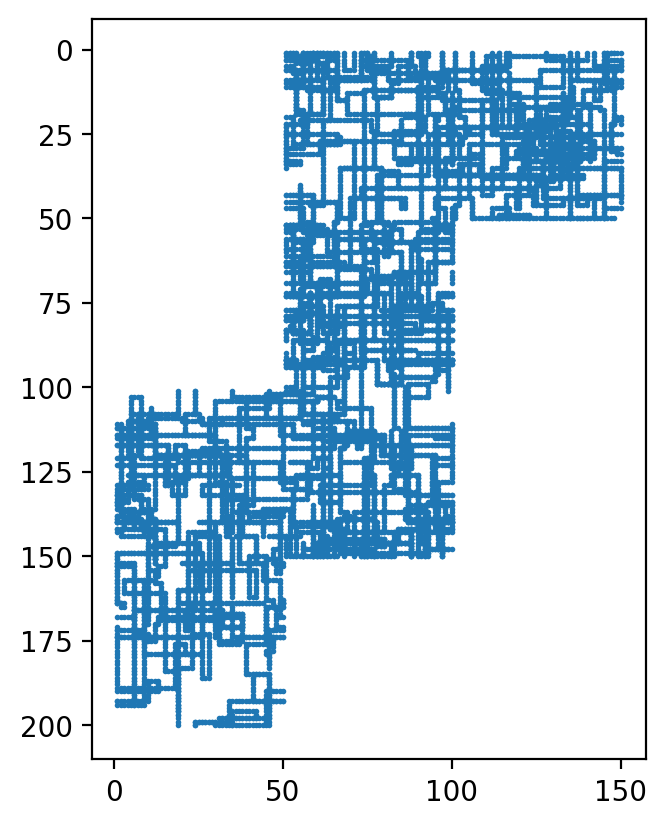

In [425]:
fig,ax = plt.subplots()
ax.plot(*np.array(traj).T[:2],'.',ms=2)
ax.invert_yaxis()
ax.set_aspect('equal')

In [396]:
you = Hiker(Point(9,1))
traj = []
for o in exgps:
    you.move(o,exgrove,log=traj)
you.finalpassword()

6032

In [426]:

@dataclass
class CubicGrove(Grove):

    faces : dict
    cubesize : int = 50

    
    def getface(self,point):
        return (point.x-1)//self.cubesize,(point.y-1)//self.cubesize
    
    def faceorigin(self,face):
        return Point(self.cubesize*face[0]+1,self.cubesize*face[1]+1)

    def wrap(self,point,dir):
        f = self.getface(point)

        nf,nd = self.faces[f][dir]
        originnewface = self.faceorigin(nf)
        wrappedoldfaceorigin = originnewface+ Point.fromdir(nd,self.cubesize-1) #-1 to have the point on the new face
        rotpoint = point.rotate(nd.opposite().value-dir.value)
        originrotpt = self.faceorigin(self.getface(rotpoint))
        wrappedpoint = rotpoint-originrotpt+wrappedoldfaceorigin

        return wrappedpoint,nd.opposite()


    @classmethod
    def frominput(cls,grovestr,cubesize=50):
        faces = {}

        flatgrove = Grove.frominput(grovestr)
        grove = cls(flatgrove.data,flatgrove.xmax,flatgrove.ymax,faces,cubesize)

        Nx = (grove.xmax-1)//cubesize
        Ny = (grove.ymax-1)//cubesize
        for ny,nx in itertools.product(range(Ny),range(Nx)):
            # print(nx,ny,(Nx*nx+1,Ny*ny+1),grove[(Nx*nx+1,Ny*ny+1)])
            if grove[(cubesize*nx+1,cubesize*ny+1)] != Tile.Void:
                grove.faces[(nx,ny)] = {dir:None for dir in Dir}
                for d,neigh in zip(Dir,[(nx+1,ny),(nx,ny+1),(nx-1,ny),(nx,ny-1)]):
                    neighx,neighy=neigh
                    if grove[(cubesize*neighx+1,cubesize*neighy+1)]!=Tile.Void:
                        grove.faces[(nx,ny)][d] = (neigh,d.opposite())

        for _ in range(2):
            for face,edges in grove.faces.items():
                for d in Dir:
                    if edges[d] is not None and edges[d.turn(Turn.R)] is not None:
                        e1,d1 = edges[d]
                        e2,d2 = edges[d.turn(Turn.R)]
                        grove.faces[e1][d1.turn(Turn.L)] = (e2,d2.turn(Turn.R))
                        grove.faces[e2][d2.turn(Turn.R)] = (e1,d1.turn(Turn.L))


        return grove

In [427]:
cubicgrove = CubicGrove.frominput(grovestr)
excubicgrove = CubicGrove.frominput(exgrovestr,cubesize=4)

In [430]:
groveplot = np.zeros((201,151))
for p,t in cubicgrove.data.items():
    if t==Tile.Wall:
        groveplot[p.y,p.x]= 2
    elif t==Tile.Open:
        groveplot[p.y,p.x]= 1

In [437]:
you = Hiker(Point(51,1))
traj = []
for o in gps:
    you.move(o,cubicgrove,log=traj)
you.finalpassword()

126017

In [434]:
you = Hiker(Point(9,1))
traj = []
for o in exgps:
    you.move(o,excubicgrove,log=traj)
you.finalpassword()

5031

In [441]:
np.array(traj).T[:2]

array([[52, 53, 54, ..., 6, 5, 4],
       [1, 1, 1, ..., 126, 126, 126]], dtype=object)

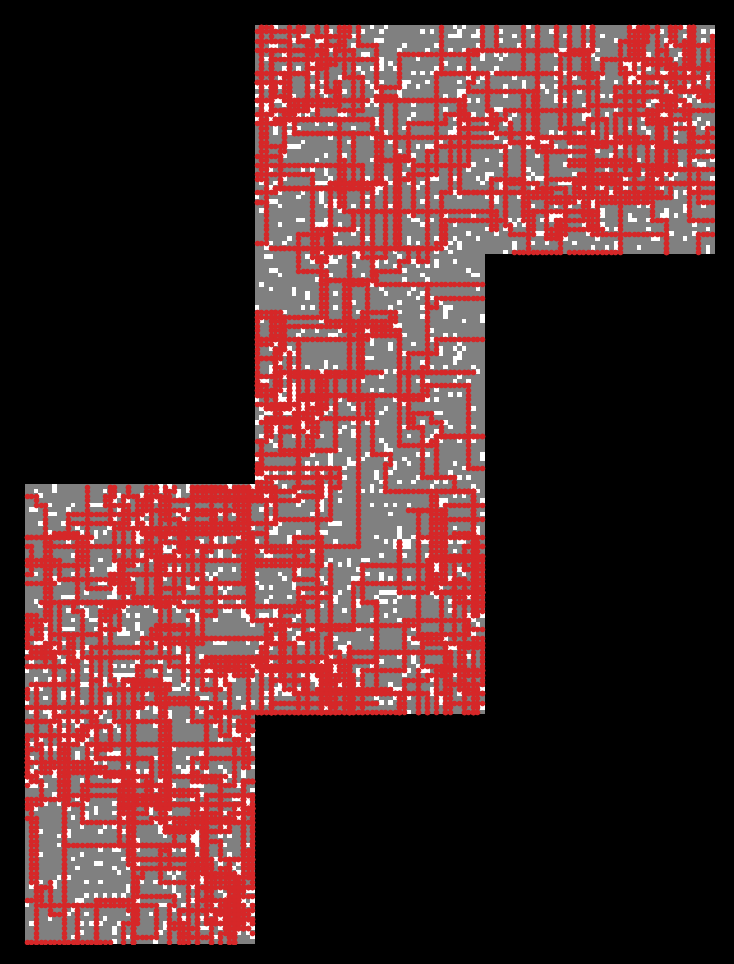

In [448]:
fig,ax = plt.subplots(figsize=(8,6))
ax.axis("off")
fig.set_facecolor("k")
ax.imshow(groveplot,cmap="gray")
ax.plot(*np.array(traj).T[:2],".",c="tab:red",ms=2)

